**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [62]:
#Install Objax
!pip --quiet install  objax
import objax

In [63]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [64]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

1.(1 point) Your data has been split into training, validation and test set. Examine the ratio of the split and number of examples in each set. Suppose you were to train on batches of 32 examples each. That is, in each step of gradient descent, you randomly select 32 examples from the training set, compute your average loss on these examples, and then compute the gradient of this average loss with respect to the model parameters.

How many iterations will it take to go through the entire training set given the number of training examples yielded by the data split? How many iterations are there in 30 epochs? Recall that one epoch is the number of iterations needed to train over the entire dataset.

In [65]:
X_train.shape

(48000, 3, 32, 32)

With 48000 training examples, at batch of 32 examples each, each epoch will require 48000/32 = 1500 iterations to go through the entire training set.

In 30 epochs, there are 30 * 1500 = 45000 total iterations.

4.(1 point) Explain in a short paragraph what is the difference between the training and validation set.

The training set is used to learn parameters of the model through numerical methods including gradient descent. 

The validatino set is used to learn hyperparameters of the model typically by training multiple models on the training set with varying hyperparameter values and testing on the validation set. Then, the hyperparameters corresponding to the lowest validation loss are chosen.


Next we will construct a **Base Model**, which in our case is a small CNN.

In [66]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



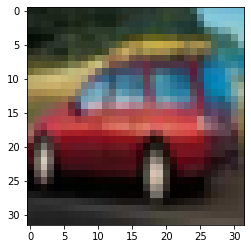

In [67]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [68]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[-0.0836635   0.29303992]
   [-0.6150833  -0.30144012]
   [-0.7410647  -0.3469479 ]]]]
Conv output: [[[[-0.15979855 -0.15415223 -0.13430713 ... -1.131044   -1.1131169
    -1.1040704 ]
   [-0.21626174 -0.18561804 -0.19077031 ... -1.1492877  -1.1445751
    -1.1389288 ]
   [-0.22190806 -0.18803014 -0.21900192 ... -1.1428583  -1.1436299
    -1.1383154 ]
   ...
   [-0.24843808 -0.23714544 -0.23714544 ... -0.31025857 -0.3159049
    -0.33284384]
   [-0.20891383 -0.1976212  -0.1976212  ... -0.34413648 -0.33849016
    -0.33849016]
   [-0.18632856 -0.18068224 -0.18632856 ... -0.42318496 -0.41753864
    -0.4005997 ]]

  [[-0.04659335 -0.04519983 -0.03965868 ... -0.38578457 -0.3812471
    -0.37831452]
   [-0.06052857 -0.05237884 -0.0535939  ... -0.37775952 -0.38081717
    -0.37942368]
   [-0.06192209 -0.05356096 -0.06056151 ... -0.35802466 -0.36495265
    -0.3662144 ]
   ...
   [-0.06131497 -0.05852792 -0.05852792 ... -0.05848081 -0.05987434
    -0.0640549 ]
   [-0.05156032 -0.0

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [69]:
#Solution to the above problem

def my_conv_net(my_image, initial_filter_weights):
  N, C_in, H_in, W_in = my_image.shape
  k, _, _, C_out = initial_filter_weights.shape
  H_out = H_in - k + 1
  W_out = W_in - k + 1
  my_conv_output = jn.zeros((N, C_out, H_out, W_out))
  total = 0
  for n in range(N):
    for c in range(C_out):
      for h in range(H_out):
        for w in range(W_out):
          my_conv_output = my_conv_output.at[n, c, h, w].set(np.sum(my_image[n,:,h:h+k, w:w+k]*initial_filter_weights[:,:,:,c].transpose(2,0,1)))
  return my_conv_output

In [70]:
#test function
my_conv_output = my_conv_net(my_image, filter_weights)

In [71]:
print("Conv output:", my_conv_output)
print('Conv output shape:', my_conv_output.shape)
print('Conv output absolute mean difference', np.mean(np.absolute((my_conv_output - Conv2d(my_image)))))

Conv output: [[[[-0.15979853 -0.15415221 -0.13430712 ... -1.131044   -1.113117
    -1.1040704 ]
   [-0.21626174 -0.18561804 -0.19077033 ... -1.1492877  -1.1445751
    -1.1389288 ]
   [-0.22190806 -0.18803014 -0.21900192 ... -1.1428583  -1.1436299
    -1.1383154 ]
   ...
   [-0.24843806 -0.23714542 -0.23714542 ... -0.31025857 -0.31590486
    -0.33284384]
   [-0.20891383 -0.1976212  -0.1976212  ... -0.34413648 -0.33849016
    -0.33849016]
   [-0.18632856 -0.18068224 -0.18632856 ... -0.42318496 -0.41753864
    -0.4005997 ]]

  [[-0.04659335 -0.04519983 -0.03965868 ... -0.38578457 -0.3812471
    -0.37831455]
   [-0.06052857 -0.05237884 -0.0535939  ... -0.37775952 -0.38081717
    -0.37942368]
   [-0.06192209 -0.05356096 -0.06056151 ... -0.35802466 -0.36495268
    -0.3662144 ]
   ...
   [-0.06131497 -0.05852792 -0.05852792 ... -0.05848081 -0.05987434
    -0.0640549 ]
   [-0.05156032 -0.04877327 -0.04877327 ... -0.06684195 -0.06544843
    -0.06544843]
   [-0.04598623 -0.0445927  -0.04598623 .

Since my convolution output differs from Conv2d by ~5.21e-9 and that it has the same output shape, I can confirm that it performs the same function as Objax's.

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [72]:
#Check that .mean((2,3)) rearranges your image
my_conv_output.mean((2,3))

DeviceArray([[-0.39710045, -0.07775426]], dtype=float32)

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [73]:
X = my_conv_output.mean((2,3))
N = X.shape[1]
Linear_Layer = objax.nn.Linear(N,1)
Y = Linear_Layer(X)

w = Linear_Layer.w.value
b = Linear_Layer.b.value

#ONE LINE HERE
my_Y = np.matmul(X,w)+b

#Verify that values are same
print(Y, my_Y)

[[-0.49124828]] [[-0.49124828]]


My Y value is equal to the Objax output.

You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [74]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params - grad*lr)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [75]:
def train(EPOCHS = 50, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 12.47 Validation Accuracy 15.65
Epoch 0002  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 14.25 Validation Accuracy 14.07
Epoch 0003  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 13.84 Validation Accuracy 14.20
Epoch 0004  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 14.19 Validation Accuracy 15.65
Epoch 0005  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 15.84 Validation Accuracy 16.27
Epoch 0006  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 16.29 Validation Accuracy 16.78
Epoch 0007  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 17.12 Validation Accuracy 17.57
Epoch 0008  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 17.49 Validation Accuracy 18.50
Epoch 0009  Training Loss 2.24 Validation Loss 2.24 Training Accuracy 18.37 Validation Accuracy 18.83
Epoch 0010  Training Loss 2.23 Validation Loss 2.22 Training Accuracy 18.80 Valida

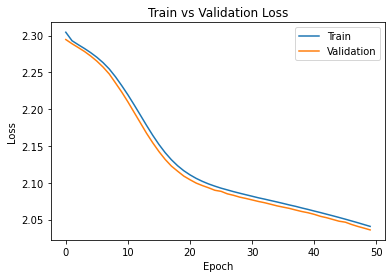

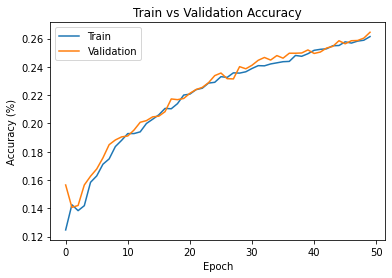

In [76]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

4.(1 point) In one sentence, define the meaning of a “hyperparameter”. Explain in a short paragraph why it is important not to evaluate the accuracy on the test set until all hyperparameters have been tuned.

Hyperparameters are parameters that cannot be learned by gradient descent on the training set. Instead, they are intialized/chosen when the model is generated and affect the models behaviour and performance. 

The accuracy on the test set represents generalizability of the model. Thus, it should only be evaluated once with our final model. After training parameters on the training set and tuning hyperparameters on the validation set, their values are set. Finally, test set is input to the model only once. 

5.(2 points) Select 4 hyperparameters associated with your network, one of the hyperparameter must involve your CNN architecture, and come up with two different sets of hyperparameters.

I selected the learning rate, batch size, number of convolutional layers, and the activation function for each convolutional layer.

H1 = {0.001, 32, 2, ReLU}
H2 = {0.0001, 16, 3, SELU}

6.(3 points) Create two additional networks M1, M2, each with the set of hyperparameter H1, H2 that you have selected above. Train each model. Report the best validation accuracy as well as the corresponding epoch for which this occurs for the Base Model and your two additional models.

In [77]:
#Create M1
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    #RELU ACTIVATION
    #2 CONV LAYERS
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()

In [78]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params - grad*lr)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [79]:
def train_M1(EPOCHS = 50, BATCH = 32, LEARNING_RATE = 0.001):   # 0.001 LR, SIZE 32 BATCH
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss for M1")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy for M1")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()


In [ ]:
train_M1()

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 11.88 Validation Accuracy 13.63
Epoch 0002  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 13.70 Validation Accuracy 13.65
Epoch 0003  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 14.37 Validation Accuracy 14.60
Epoch 0004  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 15.19 Validation Accuracy 15.62
Epoch 0005  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 15.90 Validation Accuracy 16.62
Epoch 0006  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 16.34 Validation Accuracy 18.08
Epoch 0007  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 17.68 Validation Accuracy 18.97
Epoch 0008  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 18.34 Validation Accuracy 17.58
Epoch 0009  Training Loss 2.23 Validation Loss 2.22 Training Accuracy 18.47 Validation Accuracy 18.00
Epoch 0010  Training Loss 2.21 Validation Loss 2.20 Training Accuracy 18.73 Valida

In [ ]:
#Create M2
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    #SELU ACTIVATION
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.selu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.selu])
    #3 CONV LAYERS
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.selu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params - grad*lr)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train_M2(EPOCHS = 50, BATCH = 16, LEARNING_RATE = 0.0001):  #0.0001 LR, SIZE 16 BATCH
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss for M2")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy for M2")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()


In [ ]:
train_M2()

You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


##**Problem 4. Open-Ended Exploration**

See the handout for instructions.